#  Прогнозирование заказов такси

Агрегатор такси предоставляет данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить модель на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
#импортируем нужные библиотеки
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor 

#давим варнинги
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
#открываем и изучаем файл 
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
#проверяем хронологический порядок в датах
print(data.index.is_monotonic)

True


Время расположено в хронологическом порядке. Сортировка не нужна.

In [5]:
#проверяем распределение заказов
data['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

In [6]:
#увеличиваем интервал до 1 часа
data = data.resample('1H').sum()
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

Чтобы не изменять исходный датафрейм, анализ будем проводить на его копии.

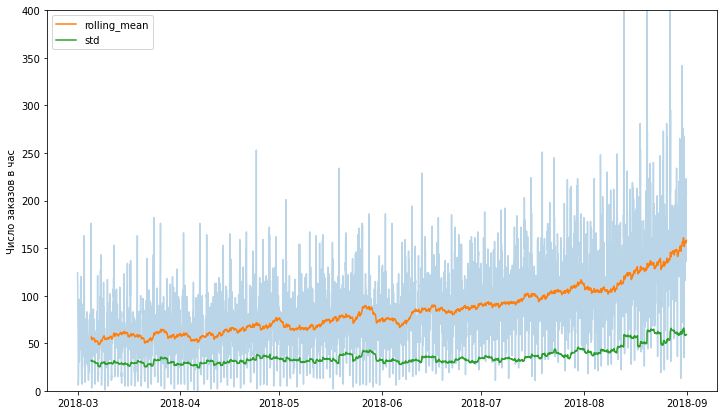

In [7]:
df = data.copy()
df['rolling_mean'] = df['num_orders'].rolling(100).mean()
df['std'] = df['num_orders'].rolling(100).std()
plt.figure(figsize=(12,7))
plt.plot(df.index, df['num_orders'], alpha=0.3)
plt.plot(df.index, df['rolling_mean'], label='rolling_mean')
plt.ylabel('Число заказов в час')
plt.plot(df.index, df['std'], label='std')
plt.ylim(0,400)
plt.legend()
plt.show()

Ряд не стационарен. Со временем среднее количество заказов растет, особенно в августе. Стандартное отклонение также меняется в конце августа. Это может говорить о росте компании. Возможно также, что это сезонность, которую мы не можем зафиксировать на имеющихся данных (нужен более широкий диапазон). Более подробно проанализируем данные после разбиения на тренд и сезонность.

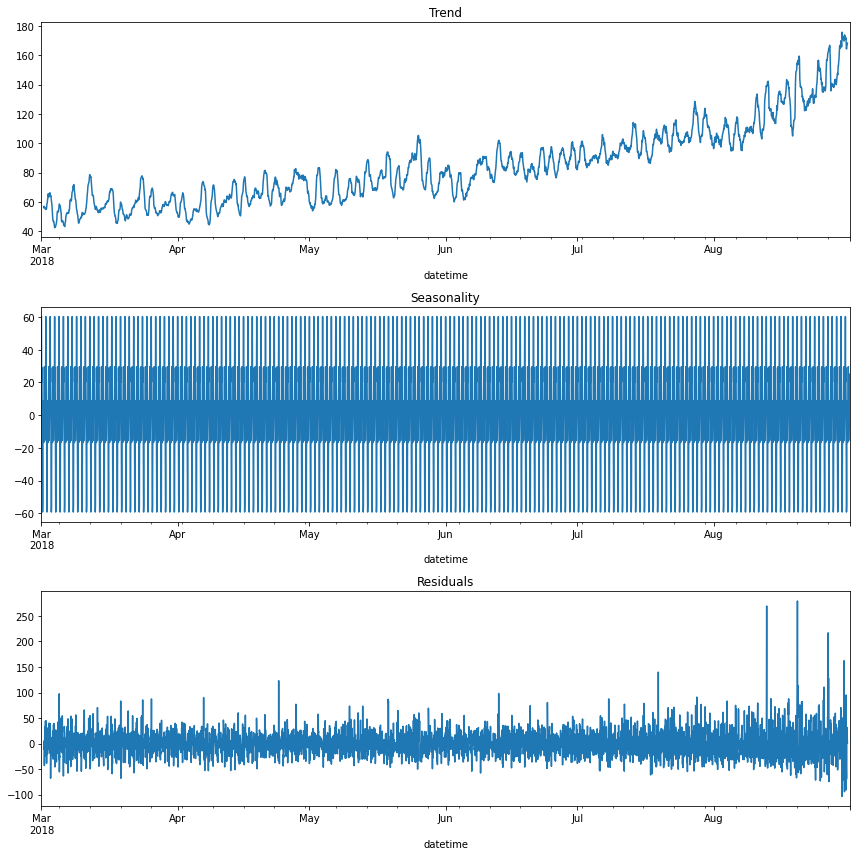

In [8]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(3,1,2)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(3,1,3)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Проанализируем сезонность в более узком диапазоне.

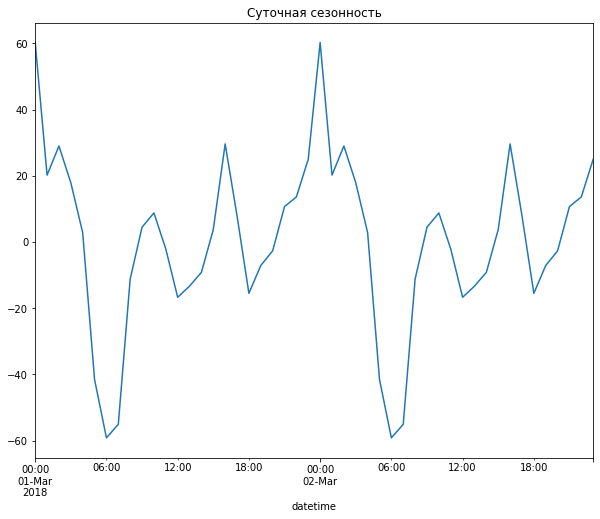

In [9]:
plt.figure(figsize=(10,8))
decomposed.seasonal['2018-03-01':'2018-03-02'].plot()
plt.title('Суточная сезонность')
plt.show()

В течение дня число заказов такси увеличивается, за исключением небольших локальных минимумов в 12:00 и 18:00. Максимальное число заказов приходится на 0:00. Затем происходит резкое падение до минимальных суточных значений в 6:00. 

## Обучение

In [10]:
#создаем функцию для формирования признаков
def make_features(data, max_lag, rolling_mean_size):
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()  

In [11]:
#применяем функцию
make_features(data, 1, 24)

In [12]:
#удаляем строки с пропусками
data = data.dropna()
display(data)

,num_orders,day_of_week,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-02 00:00:00,90,4,0,58.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,56.958333
...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,168.041667


In [13]:
#выделяем целевой признак и признаки
features = data.drop('num_orders', axis=1)
target = data['num_orders']

#разделяем выборку на обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3952, 4)
(440, 4)
(3952,)
(440,)


In [14]:
#создаем оценщик моделей

def rmse_function(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return abs(mse)**0.5

rmse = make_scorer(rmse_function, greater_is_better=False)

In [15]:
#настраиваем кросс-валидацию
tscv = TimeSeriesSplit(n_splits=8)

In [16]:
#создаем словарь для записи результатов моделей
results = {'training_time': [],
           'pred_time': [],
           'cv_rmse': [],
           'test_rmse': []
          }

### Линейная регрессия

In [17]:
#проверяем модель линейной регрессии на кросс-валидации
model_lr = LinearRegression()
cv_lr = cross_val_score(estimator=model_lr, 
                      X=features_train,
                      y=target_train, 
                      scoring=rmse,
                      cv=tscv, 
                      n_jobs=-1)

print(abs(cv_lr.mean()))

31.34322751744601


In [19]:
#создаем функцию для автоматизации моделирования и записи результатов
def modelling(model, features_train, target_train, features_test, target_test, cv_res):
    start_train = time.time()
    model.fit(features_train, target_train)
    stop_train = time.time()
    pred_test = model.predict(features_test)
    stop_test = time.time()
    results.setdefault('training_time',[]).append('{0:.3f}'.format(stop_train-start_train))
    results.setdefault('pred_time',[]).append('{0:.3f}'.format(stop_test-stop_train))
    results.setdefault('test_rmse',[]).append('{0:.2f}'.format(rmse_function(target_test, pred_test)))
    results.setdefault('cv_rmse',[]).append('{0:.2f}'.format(abs(cv_res.mean())))
    display(results)
    table = pd.DataFrame({'true': target_test, 'predictions': pred_test})
    matplotlib.style.use('seaborn-dark') 
    plt.figure(figsize=(16,8))
    plt.plot(table['true']['2018-08-15':'2018-08-17'], label='True')
    plt.plot(table['predictions']['2018-08-15':'2018-08-17'], label='Predictions')
    plt.legend()
    plt.title('Результаты модели за 2 дня')
    plt.xlabel('Дата и время')
    plt.ylabel('Число заказов')
    plt.grid(True)
    plt.show()

{'training_time': ['0.003'],
 'pred_time': ['0.002'],
 'cv_rmse': ['31.34'],
 'test_rmse': ['51.22']}

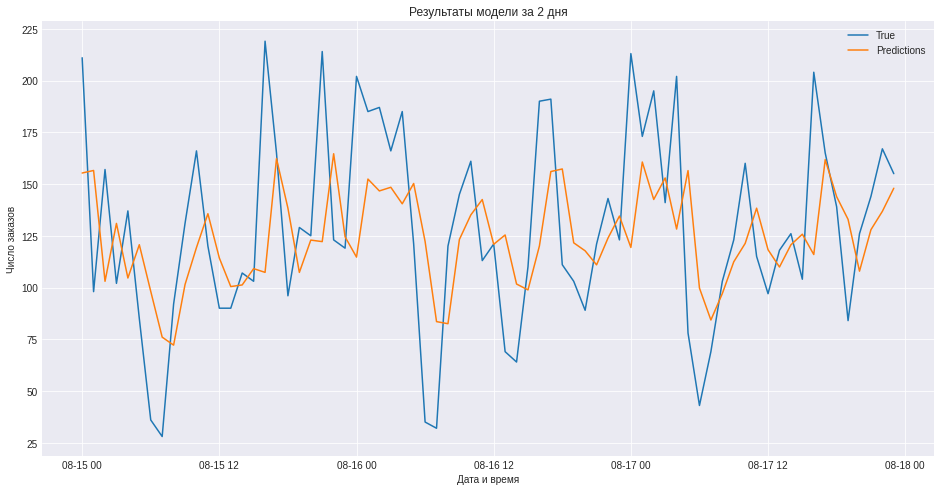

In [20]:
#применяем функцию к модели
modelling(model_lr, features_train, target_train, features_test, target_test, cv_lr)

* Кривая предсказаний линейной регрессии повторяет форму реальных данных, однако не предсказывает слишком высоких и низких значений.

### Дерево решений

In [21]:
%%time

model_dt = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth': range(3,21,1)}
grid_dt = GridSearchCV(model_dt, param_grid=parameters, scoring=rmse, n_jobs=-1, cv=tscv)
grid_dt.fit(features_train, target_train)
cv_dt= grid_dt.best_score_
print(grid_dt.best_params_)
print(abs(grid_dt.best_score_))

{'max_depth': 6}
28.619943198483824
CPU times: user 1.28 s, sys: 6.51 ms, total: 1.28 s
Wall time: 1.29 s


{'training_time': ['0.003', '0.007'],
 'pred_time': ['0.002', '0.001'],
 'cv_rmse': ['31.34', '28.62'],
 'test_rmse': ['51.22', '51.74']}

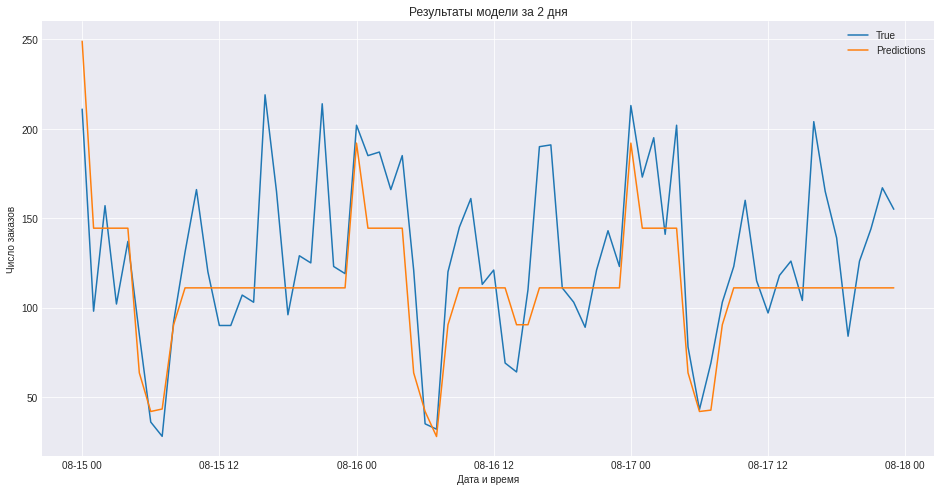

In [22]:
modelling(grid_dt.best_estimator_, features_train, target_train, features_test, target_test, cv_dt)

* Дерево решений выдает ограниченные варианты ответов и плохо подстраивается под колебания.

### Случайный лес

In [23]:
%%time

model_rf = RandomForestRegressor(random_state=12345)
parameters = {'max_depth': range(3,16,1), 'n_estimators' : [10, 20, 40, 60, 100, 200, 300, 500]}
grid_rf = GridSearchCV(model_rf, param_grid=parameters, scoring=rmse, n_jobs=-1, cv=tscv)
grid_rf.fit(features_train, target_train)
cv_rf= grid_rf.best_score_
print(grid_rf.best_params_)
print(abs(grid_rf.best_score_))

{'max_depth': 13, 'n_estimators': 300}
24.75513046665094
CPU times: user 6min 19s, sys: 2.08 s, total: 6min 21s
Wall time: 6min 21s


{'training_time': ['0.003', '0.007', '1.936'],
 'pred_time': ['0.002', '0.001', '0.034'],
 'cv_rmse': ['31.34', '28.62', '24.76'],
 'test_rmse': ['51.22', '51.74', '45.85']}

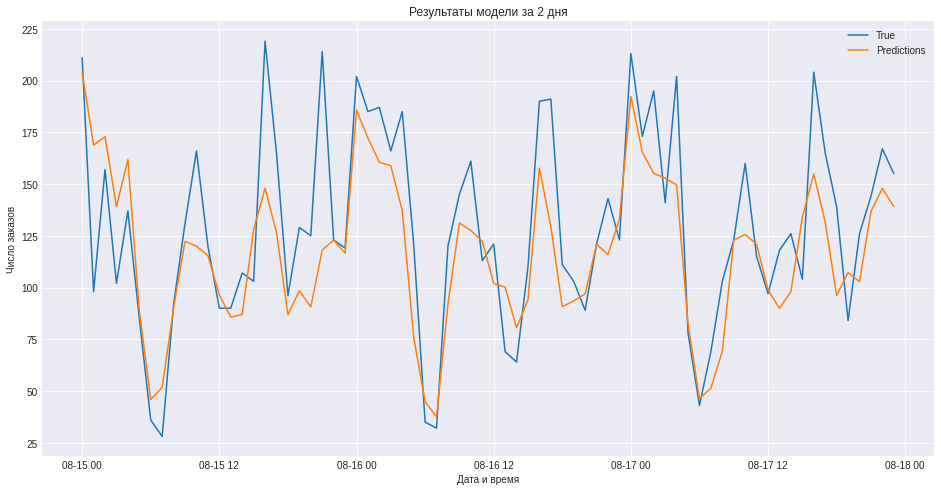

In [24]:
modelling(grid_rf.best_estimator_, features_train, target_train, features_test, target_test, cv_rf)

* Случайный лес чаще всего выдает предсказания, близкие к реальным. Кривая предсказаний повторяет форму реальных данных.

### Градиентный бустинг LGBM

In [26]:
#столбцам с категориальными признаками присваиваем формат категорий
cat_columns = ['day_of_week', 'hour']
features_train[cat_columns] = features_train[cat_columns].astype('category')
features_test[cat_columns] = features_test[cat_columns].astype('category')

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [27]:
%%time

model_lgbm = LGBMRegressor(n_jobs=-1, random_state=12345)
parameters = {'learning_rate': [0.1, 0.2, 0.3],
              'max_depth': [3, 6, 10, 15],
              'n_estimators': [100, 200, 300, 500]
             }
grid_lgbm = GridSearchCV(model_lgbm, param_grid=parameters, cv=tscv, scoring=rmse)

grid_lgbm.fit(features_train, target_train)
cv_lgbm = grid_lgbm.best_score_

print(grid_lgbm.best_params_)
print(grid_lgbm.best_score_)

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
-24.31330599961297
CPU times: user 2h 34min 51s, sys: 1min 38s, total: 2h 36min 30s
Wall time: 2h 37min 39s


{'training_time': ['0.003', '0.007', '1.936', '0.606'],
 'pred_time': ['0.002', '0.001', '0.034', '0.089'],
 'cv_rmse': ['31.34', '28.62', '24.76', '24.31'],
 'test_rmse': ['51.22', '51.74', '45.85', '40.86']}

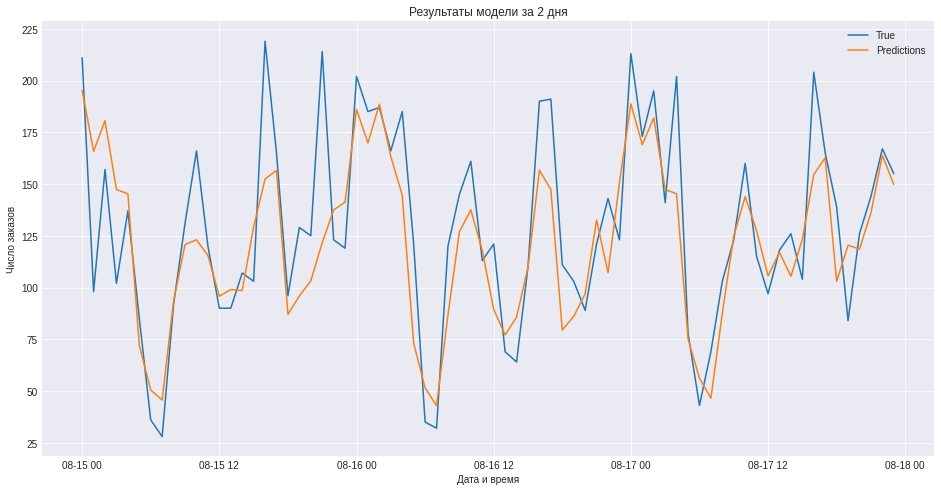

In [28]:
modelling(grid_lgbm.best_estimator_, features_train, target_train, features_test, target_test, cv_lgbm)

* Кривые предсказаний и реальных данных на большинстве участков почти совпадают. Это самая точная модель из всех исследованных.

## Выводы

In [29]:
#строим таблицу с результатами
columns = pd.Series(['Linear_Regression', 'Decision_Tree', 'Random_Forest', 'LGBM_Regressor'])
table = pd.DataFrame.from_dict(results, orient='index', columns=columns)
display(table)

,Linear_Regression,Decision_Tree,Random_Forest,LGBM_Regressor
training_time,0.003,0.007,1.936,0.606
pred_time,0.002,0.001,0.034,0.089
cv_rmse,31.34,28.62,24.76,24.31
test_rmse,51.22,51.74,45.85,40.86


* Простые модели (линейная регрессия и решающее дерево) обучаются и предсказывают в десятки и сотни раз быстрее других моделей. Но и точность у них самая низкая, они не подходят под требования заказчика.

* Модель случайного леса очень долго обучается и предсказывает. Но имеет выше точность, по сравнению с простыми моделями.

* Модель градиентного бустинга LGBM показала лучшую точность на тестовой выборке. У нее относительно короткое время обучения и предсказания (но все равно в десятки раз дольше, чем у простых моделей).

**Для задачи прогнозирования лучше всего использовать модель градиентного бустинга LGBM благодаря самой высокой точности и приемлемому времени обучения и предсказания.**